We try measure pulse rate from webcam of our laptop with reasonable accuracy. I got inspiration for the project from a YouTube video by [Steve Mould](https://www.youtube.com/watch?v=BFZxlauizx0) where he discussed how smart watches measure various biometics. Pressing your thumb in front of the webcam, gives a similar video feed to what a smart watch sensor might sense. We divide the project into 3 parts:

```{mermaid}
flowchart LR
  A(Capture) --> B(Clean)--> C(Count)
```
We start by importing requirements:

In [1]:
import cv2
import numpy as np
from datetime import datetime
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft

## Capture

We simply use `OpenCV` library to capture the webcam output. Each frame that `OpenCV` captures is a numpy array of shape (length,breadth,3),length and breadth corresponds to resolution of your webcam and 3 corresponds to the color space (BRG default). Every time blood is pumped, the intensity of light, passing through the thumb reaching the camera sensor changes. This change is detected by the camera as slight periodic change in pixel intensity values. Of the 3 color channels, 
- The blue light gets scattered and absorbed easily, and the intensity changes is not very clear and image output is noisy. 
- On the other hand red light is least scattered and absorbed which leads to much cleaner image but intensity changes are little.
- Green performs the best. producing cleaner image with significant intensity changes.

This is the reason why most smart watches have a green flashing light.

Once we capture the frame, we average out the pixel intensity for each color for each frame. 

In [2]:
def vid_capture(nframes,ndead_frames):
    # define a video capture object
    vid = cv2.VideoCapture(0)
    sampling_rate=vid.get(cv2.CAP_PROP_FPS)
    # print(f"sampling_rate {sampling_rate} Hz")
    i=0  
    Color0=np.array([])
    Color1=np.array([])
    Color2=np.array([])
    while(i< nframes+ndead_frames):

        # Capture the video frame
        # by frame
        ret, frame = vid.read()
        # Display the resulting frame
        cv2.imshow('frame', frame)
        Color0=np.append(Color0,frame[:,:,0].mean()) # avg pixel blue intensith
        Color1=np.append(Color1,frame[:,:,1].mean()) # avg pixel red intensith
        Color2=np.append(Color2,frame[:,:,2].mean()) # avg pixel green intensith
        i=i+1
        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()
    return Color0,Color1,Color2,sampling_rate

## Clean

We have a time series of pixel intensity values. We remove the trend from this series to get a clear view of the periodic intensity changes. We remove trend by subtracting a rolling average from the intensities. We ignore first few frames (`ndead_frames`) because the camera takes some time to auto adjust to the light level, thus the pixel intensity in the first few frames are way off.

In [3]:
def trend_remove(Color0,Color1,Color2,ndead_frames,roll=5):    
    df=pd.DataFrame({"color0":Color0,"color1":Color1,"color2":Color2})
    df["trend0"]=df["color0"].rolling(roll).mean()
    df["trend1"]=df["color1"].rolling(roll).mean()
    df["trend2"]=df["color2"].rolling(roll).mean()
    df["corrected0"]=df["color0"]-df["trend0"]
    df["corrected1"]=df["color1"]-df["trend1"]
    df["corrected2"]=df["color2"]-df["trend2"]
    plt.figure(figsize = (10,5))
    plt.tight_layout()
    plt.subplot(321)
    plt.title("Avg intensity vs frames")
    plt.plot(df["color0"][ndead_frames:])
    plt.subplot(322)
    plt.title("Avg intensity (without trend) vs frames")
    plt.plot(df["corrected0"][ndead_frames:])
    plt.subplot(323)
    plt.plot(df["color1"][ndead_frames:])
    plt.subplot(324)
    plt.plot(df["corrected1"][ndead_frames:])
    plt.subplot(325)
    plt.plot(df["color2"][ndead_frames:])
    plt.subplot(326)
    plt.plot(df["corrected2"][ndead_frames:])
    plt.xlabel("frames")
    plt.show()
    return df["corrected0"][ndead_frames:],df["corrected1"][ndead_frames:],df["corrected2"][ndead_frames:]

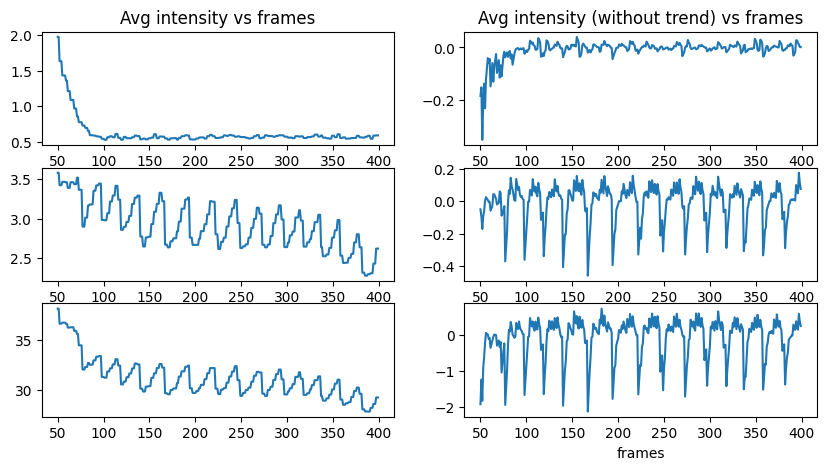

In [4]:
nframes=350        # no of frames to captue 
ndead_frames=50    # no if frames to ignore from start
Color0,Color1,Color2,sampling_rate=vid_capture(nframes,ndead_frames) # capture frames
corrected0,corrected1,corrected2=trend_remove(Color0,Color1,Color2,ndead_frames) # remove trend

## Count

Looking at above figure we see local minimas occurring at periodic intervals. This is the pulse rate we want to extract. To do this we perform a discrete Fourier transform on the time series. Doing so gives us the frequencies that constitute the time series. Then we extract the frequency of maximum amplitude which gives the pulse rate. 


In [5]:
def fft_ifft(data,sr):
    X =  fft(data)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T 

    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    plt.stem(freq, np.abs(X), 'b', \
             markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.axvline(sr/2,ls="--")
    # plt.xlim(0, sr/2)
    t = np.arange(0,T,1/sr)
    plt.subplot(122)
    plt.plot(t,ifft(X), 'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
#     plt.title("for color")
    plt.show()
    
    X_1=np.abs(X[:N//2])
    prominent_freq=freq[np.argmax(X_1)]
    # print(np.argmax(X_1))
    print(f"Pulse rate = {prominent_freq.mean()*60} +- {(freq[1]-freq[0])*60} BPM")
    
#     maxfreq=np.argsort(np.abs(X))[-2:]
#     X_2=np.zeros(N,dtype=np.complex128)
#     for i in maxfreq:
#         X_2[i]=X[i]
#     plt.plot(ifft(X),alpha=0.7)
#     plt.plot(ifft(X_2))

C:\Users\sk\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


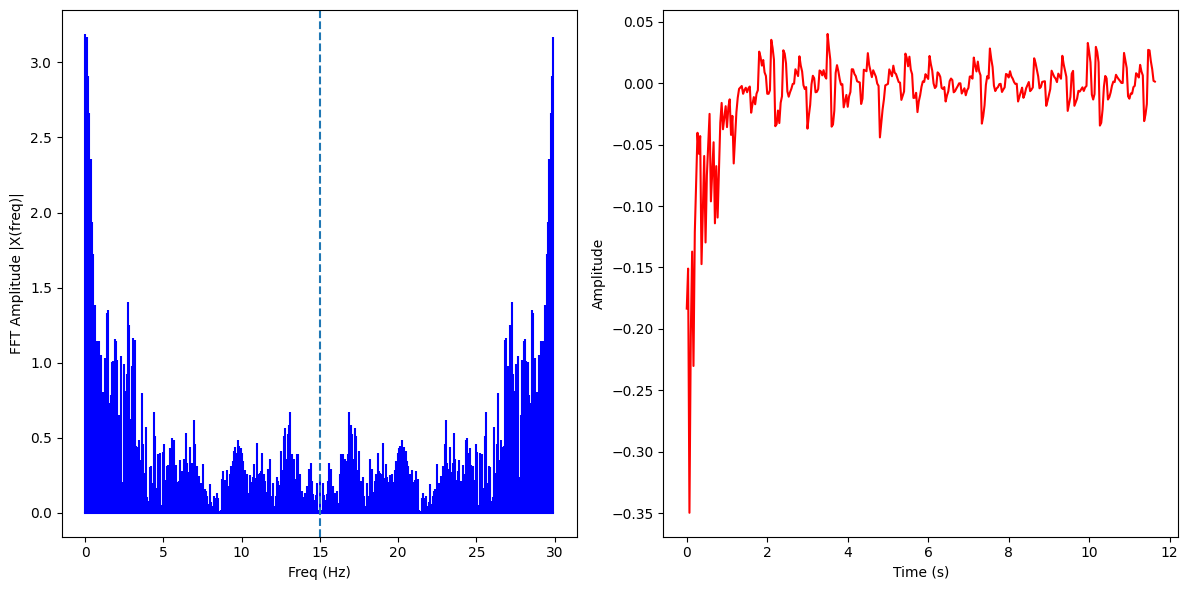

Pulse rate = 0.0 +- 5.142857142857143 BPM


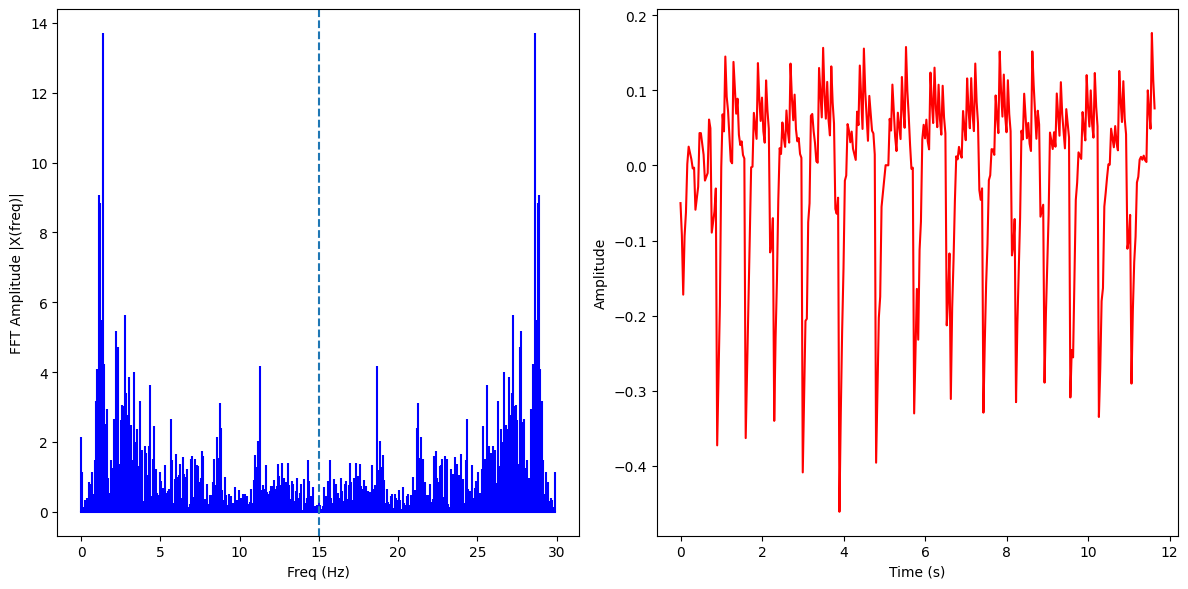

Pulse rate = 82.28571428571429 +- 5.142857142857143 BPM


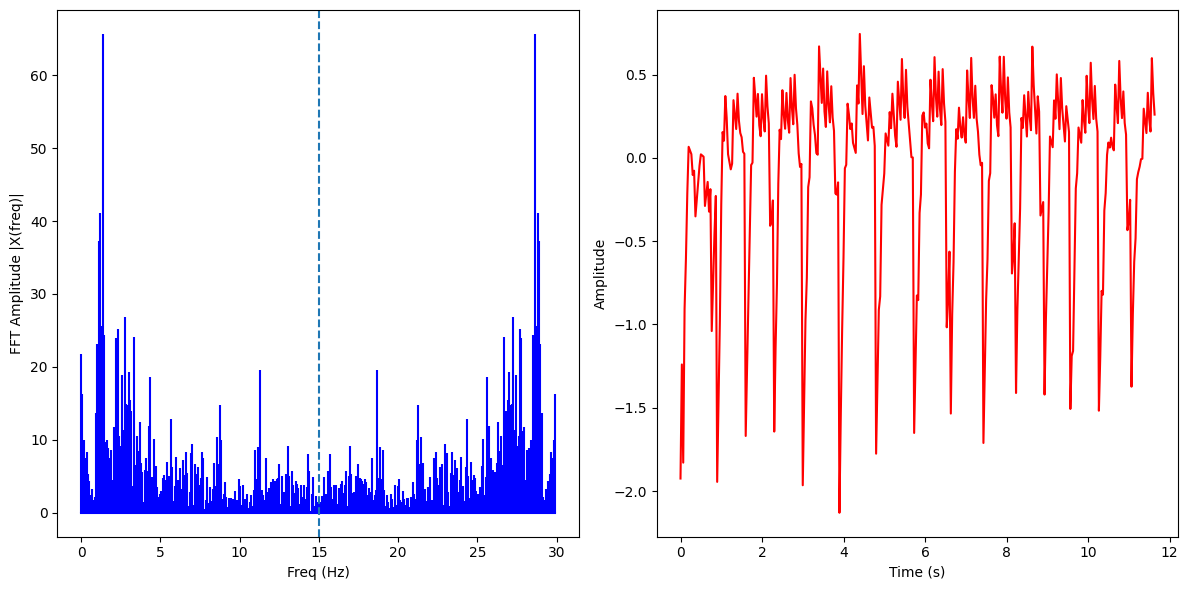

Pulse rate = 82.28571428571429 +- 5.142857142857143 BPM


In [6]:
fft_ifft(corrected0,sampling_rate)
fft_ifft(corrected1,sampling_rate)
fft_ifft(corrected2,sampling_rate)

## References
- [YouTube video by Steve Mould](https://www.youtube.com/watch?v=BFZxlauizx0)
- [A Fourier transform (FT) is a mathematical transform that decomposes functions into frequency components, which are represented by the output of the transform as a function of frequency.](https://en.wikipedia.org/wiki/Fourier_transform)